In [22]:
import pickle
import sys
sys.path.insert(0,'../')

import baseline
import zipreg
import zipgate_reg 
import zipgate_regh
import zipreg_censored
from inference import *
from criticism import *
from preprocess_bikeshare import *

In [86]:
import importlib
importlib.reload(zipgate_regh )

<module 'zipgate_regh' from '../zipgate_regh.py'>

In [23]:
with open('../data/demand_sample.pickle', 'rb') as f:
    data_samp = pickle.load(f)

In [24]:
train = data_samp.sample(frac=0.5, random_state=42)
test = data_samp.drop(train.index)


### Some Viz

In [25]:
import sqlite3
conn = sqlite3.connect('../data/sf_bikeshare.sqlite')

stations = get_station_info(conn = conn)


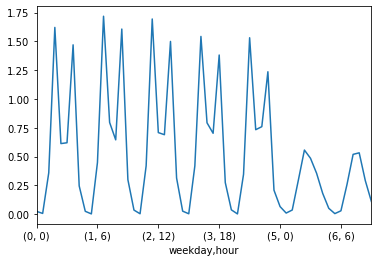

In [26]:
train.groupby(['weekday','hour'])['demand'].mean().plot()


In [27]:
avg_station_day=(train.groupby(['start_station_id', 'weekday'])
                           ['demand'].mean().reset_index()
                           .merge(stations, left_on='start_station_id', right_on='id'))

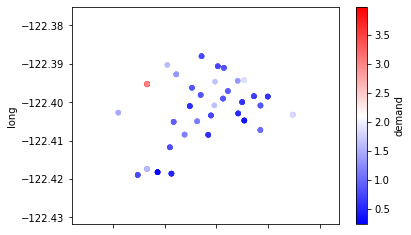

In [28]:
(avg_station_day.query('city == "San Francisco" & weekday<5 ')
.plot.scatter(x='lat', y = 'long',c ='demand', colormap='bwr'))

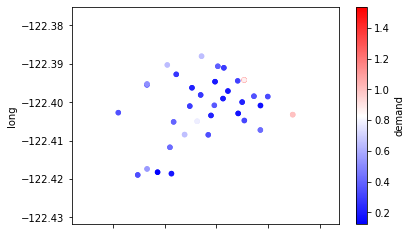

In [29]:
(avg_station_day.query('city == "San Francisco" & weekday>=5 ')
.plot.scatter(x='lat', y = 'long',c ='demand', colormap='bwr'))

### Baseline

In [105]:
b_data, b_features = baseline.feature_generation(train)
b_data_test, _ = baseline.feature_generation(test)
b = baseline.PoissReg(b_features, b_data)

../baseline.py:83: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  with pyro.plate("data", len(data)):
Elbo loss: 275026.21875
Elbo loss: 137527.890625
Elbo loss: 93266.4296875
Elbo loss: 77544.75
Elbo loss: 67703.2578125
Elbo loss: 63798.47265625
Elbo loss: 64406.53125
Elbo loss: 60616.9375
Elbo loss: 59820.52734375
Elbo loss: 58556.53515625


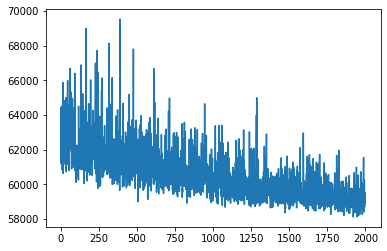

In [32]:
# Perform SVI
svi_baseline, elbo_loss = run_svi(b.model, b.guide,
                                 iters=5000,
                                 data=b_data['data'],
                                 demand=b_data['demand'],
                                 filename='../models/svi_baseline_params.pkl')

svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
                                          svi=svi_baseline)


plot_elbo(elbo_loss[3000:])

In [106]:
# Load parameters from inference
svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
                                    model = b.model,
                                  guide = b.guide,
                                  filename='../models/svi_baseline_params.pkl')


In [107]:
post_samples_base = posterior_samples(
    b.wrapped_model,
    svi_posterior_baseline,
    b_data_test,
    ['obs','lmbda_post'],
    num_samples=1000)

In [108]:
svi_posterior_baseline.information_criterion()

OrderedDict([('waic', tensor(123558.4688, grad_fn=<SumBackward0>)),
             ('p_waic', tensor(5052.3315, grad_fn=<SumBackward0>))])

Text(0.5, 1.0, 'Percent of observations with 0 demand')

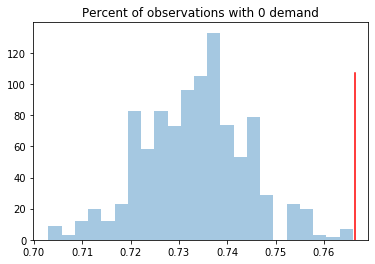

In [109]:
compare_test_statistic(test.demand.values, post_samples_base[:,0,:],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')

Text(0.5, 1.0, 'Max demand')

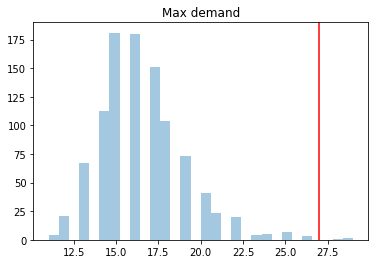

In [110]:
compare_test_statistic(test.demand.values, post_samples_base[:,0,:],
                       stat=max_)
plt.title('Max demand')

Text(0.5, 1.0, 'Avg demand')

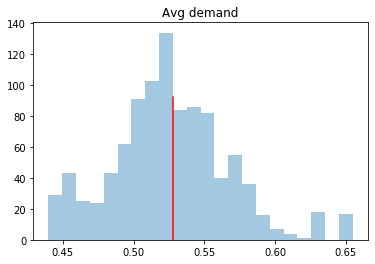

In [111]:
compare_test_statistic(test.demand.values, post_samples_base[:,0,:],
                       stat=mean)
plt.title('Avg demand')

Text(0.5, 1.0, 'Avg demand')

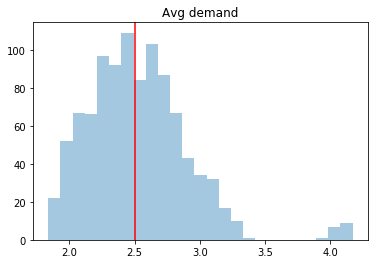

In [112]:
indx = (test.start_station_id==70)

compare_test_statistic(test.demand.values[indx], post_samples_base[:,0,indx],
                       stat=mean)
plt.title('Avg demand')

### Poisson not the right dist?

In [39]:
#Overdispersed 
print(f'Demand mean: {train["demand"].mean().round(3)}')
print(f'Demand var: {train["demand"].var().round(3)}')

Demand mean: 0.528
Demand var: 1.885


In [40]:
train.query('weekday<5').groupby(['hour']).demand.agg(['mean','var'])

,mean,var
hour,,
0,0.030105,0.039861
3,0.003985,0.006893
6,0.399273,0.863036
9,1.622596,7.891740
12,0.729102,1.393919
15,0.684084,1.381320
18,1.440134,4.412109
21,0.268425,0.428667


In [41]:
train.query('weekday>4').groupby(['hour']).demand.agg(['mean','var'])

,mean,var
hour,,
0,0.058648,0.077103
3,0.007593,0.010180
6,0.032901,0.043133
9,0.276492,0.526919
12,0.538615,1.325514
15,0.508858,1.269367
18,0.324062,0.640172
21,0.146317,0.253483


### ZIP (shared gate parameter)

In [113]:
z_data, z_features = zipreg.feature_generation(train)
z_data_test,_ = zipreg.feature_generation(test)
z = zipreg.ZIPoissReg(z_features, z_data)


../zipreg.py:115: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  gate_alpha_loc = pyro.param('gate_alpha_loc', torch.tensor(3.),
../zipreg.py:117: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  gate_beta_loc = pyro.param('gate_beta_loc', torch.tensor(3.),
../zipreg.py:152: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every

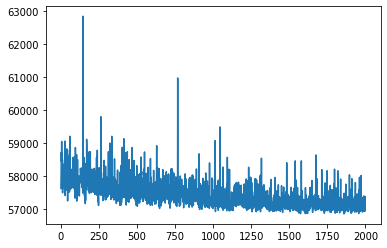

In [43]:
# Perform SVI
svi_zip, elbo_loss = run_svi(z.model, z.guide,
                                 iters=5000,
                                 data=z_data['data'],
                                 demand=z_data['demand'],
                                 filename='../models/svi_zip_params.pkl')

svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
                                          svi=svi_zip)

plot_elbo(elbo_loss[3000:])

In [44]:
svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
                                model = z.model,
                                  guide = z.guide,
                                  filename='../models/svi_zip_params.pkl')

In [114]:
post_samples_zip = posterior_samples(
    z.wrapped_model,
    svi_posterior_zip,
    z_data_test,
    ['obs'],
    num_samples=1000)

In [115]:
svi_posterior_zip.information_criterion()


OrderedDict([('waic', tensor(114990.7188, grad_fn=<SumBackward0>)),
             ('p_waic', tensor(1358.9561, grad_fn=<SumBackward0>))])

Text(0.5, 1.0, 'Percent of observations with 0 demand')

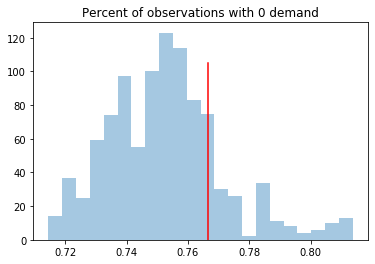

In [116]:
compare_test_statistic(test.demand.values, post_samples_zip[:,0,:],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')

Text(0.5, 1.0, 'Max demand')

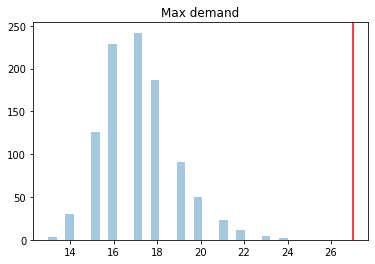

In [117]:
compare_test_statistic(test.demand.values, post_samples_zip[:,0,:],
                       stat=max_)
plt.title('Max demand')

Text(0.5, 1.0, 'Avg demand')

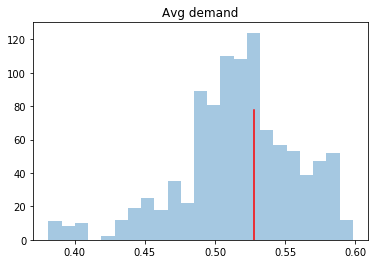

In [118]:
compare_test_statistic(test.demand.values, post_samples_zip[:,0,:],
                       stat=mean)
plt.title('Avg demand')

Text(0.5, 1.0, 'Percent of observations with 0 demand at station 70')

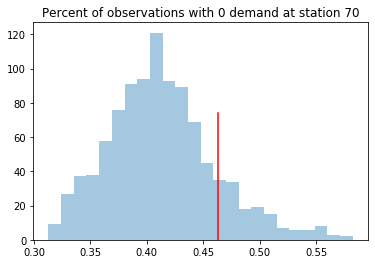

In [124]:
station_indx = ((test.start_station_id==70))
compare_test_statistic(test[station_indx ].demand.values, post_samples_zip[:,:,station_indx],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand at station 70')

### ZIP (logit gate parameter)

In [134]:
zg_data, zg_features = zipgate_reg.feature_generation(train)
zg_data_test, _ = zipgate_reg.feature_generation(test)
zg = zipgate_reg.ZIPoissRegGate(zg_features, zg_data)

../zipgate_reg.py:92: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  "obs", dist.ZeroInflatedPoisson(
Elbo loss: 207885.953125
Elbo loss: 85404.5078125
Elbo loss: 69048.0
Elbo loss: 60942.37890625
Elbo loss: 58762.53125
Elbo loss: 58503.27734375
Elbo loss: 57683.47265625
Elbo loss: 57653.1953125
Elbo loss: 57199.97265625
Elbo loss: 56655.0


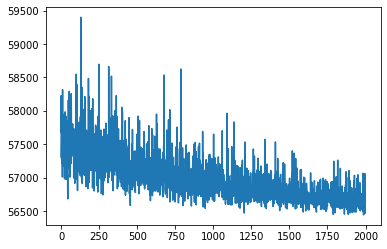

In [73]:
# Perform SVI
svi_zipgate, elbo_loss = run_svi(zg.model, zg.guide,
                                 iters=5000,
                                 data=zg_data['data'],
                                 demand=zg_data['demand'],
                                 filename='../models/svi_zipgate_params.pkl')

svi_posterior_zipgate = get_svi_posterior(zg_data['data'], zg_data['demand'],
                                          svi=svi_zipgate)

plot_elbo(elbo_loss[3000:])

In [53]:
# svi_posterior_zipgate = get_svi_posterior(zg_data['data'], zg_data['demand'],
#                                 model = zg.model,
#                                   guide = zg.guide,
#                                   filename='../models/svi_zipgate_params.pkl')

In [ ]:
post_samples_zipgate = posterior_samples(
    zg.wrapped_model,
    svi_posterior_zipgate,
    zg_data_test,
    ['obs'],
    num_samples=1000)


In [ ]:
svi_posterior_zipgate.information_criterion()


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=max_)
plt.title('Max demand')


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=mean)
plt.title('Avg demand')


In [ ]:
station_indx = ((test.start_station_id==70) )
compare_test_statistic(test[station_indx ].demand.values, post_samples_zipgate[:,:,station_indx.values ],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand at station 70 ')


### ZIP with station/hour logit for gate

In [ ]:
zgh_data, zgh_features = zipgate_regh.feature_generation(train)
zgh_data_test, _ = zipgate_regh.feature_generation(test)
zgh = zipgate_regh.ZIPoissRegGate(zgh_features, zgh_data)

../zipgate_regh.py:97: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  "obs", dist.ZeroInflatedPoisson(
Elbo loss: 173144.609375
Elbo loss: 70065.03125
Elbo loss: 61988.76953125
Elbo loss: 63332.64453125
Elbo loss: 58440.046875
Elbo loss: 57078.5390625
Elbo loss: 57491.8828125
Elbo loss: 56841.8671875
Elbo loss: 56450.390625
Elbo loss: 56655.734375


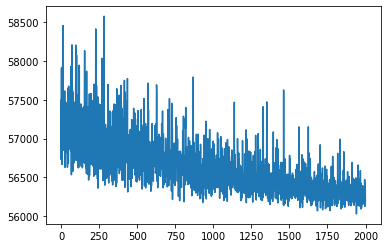

In [88]:
# Perform SVI
svi_zipgateh, elbo_loss = run_svi(zgh.model, zgh.guide,
                                 iters=5000,
                                 data=zgh_data['data'],
                                 demand=zgh_data['demand'],
                                 filename='../models/svi_zipregh_params.pkl')

svi_posterior_zipgateh = get_svi_posterior(zgh_data['data'], zgh_data['demand'],
                                          svi=svi_zipgateh)

plot_elbo(elbo_loss[3000:])

In [ ]:
# svi_posterior_zipgateh = get_svi_posterior(zgh_data['data'], zgh_data['demand'],
#                                 model = zgh.model,
#                                   guide = zgh.guide,
#                                   filename='../models/svi_zipgateh_params.pkl')

In [89]:
svi_posterior_zipgateh.information_criterion()


OrderedDict([('waic', tensor(113268.3672, grad_fn=<SumBackward0>)),
             ('p_waic', tensor(1372.5441, grad_fn=<SumBackward0>))])

In [ ]:
post_samples_zipgateh = posterior_samples(
    zgh.wrapped_model,
    svi_posterior_zipgateh,
    zgh_data_test,
    ['obs'],
    num_samples=1000)


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgateh,
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgateh,
                       stat=max_)
plt.title('Max demand')


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgateh,
                       stat=mean)
plt.title('Avg demand')


In [ ]:
station_indx = ((test.start_station_id==70))
compare_test_statistic(test[station_indx ].demand.values, post_samples_zipgateh[:,:,station_indx.values ],
                       stat=mean)
plt.title('Percent of observations with 0 demand at station 70 ')


### Station Viz

In [56]:
with open('../data/demand_3h.pickle', 'rb') as f:
    data = pickle.load(f)
    
    

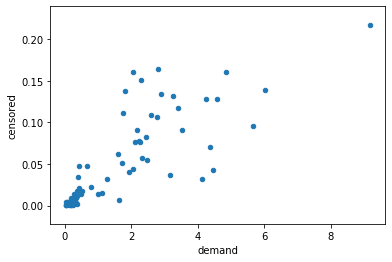

In [64]:
data.groupby('start_station_id')[['censored','demand']].mean().plot.scatter(x = 'demand', y = 'censored')
